# Writer Identification based on their Handwriting


In [180]:
#imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import os
import pathlib
import io
from collections import defaultdict
import cv2

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa

from tensorflow.python.ops import io_ops
from tensorflow.python.ops import image_ops

In [17]:
#check if gpu is available
gpus = tf.config.list_physical_devices('GPU')
if(len(gpus)==0):
    print("Running on CPU")
else:
    print("Running on GPU")  

Running on CPU


In [19]:
#Path to CVL dataset
CVL_PATH = "/mounts/layout/dkvart/data/CVL"

In [24]:
def display_rand_images(PATH, R=4, C=2, size=(10,10)):
    '''
    Given a path to a directory, randomly display the images residing there. 
    '''
    temp = 0
    MAX_SHOW = R * C
    
    #matplot figure configuration
    figure = plt.figure(figsize=(size))
    data_dir = pathlib.Path(PATH)
    
    #create a numpy array and shuffle
    filenames = np.array(list(data_dir.glob('*')))
    np.random.shuffle(filenames)
    
    for i, filename in enumerate(filenames[:MAX_SHOW], 1):
        handwriting_sample = mpimg.imread(filename)
        figure.add_subplot(R, C, i)
        plt.imshow(handwriting_sample, cmap="gray")
        plt.title(filename.stem)
    plt.show()

# CVL handwriting samples

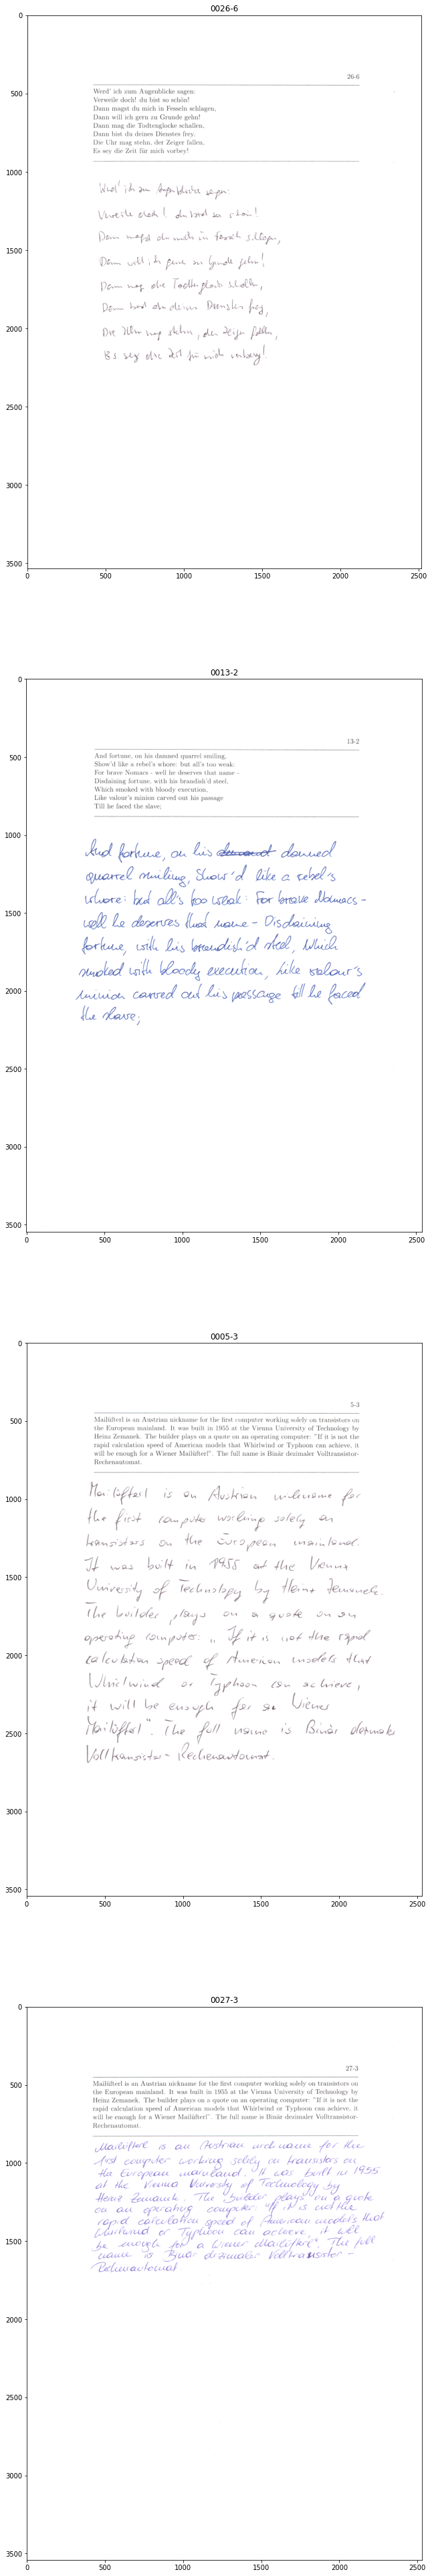

In [28]:
display_rand_images(CVL_PATH+"/trainset/pages/", R=4,C=1, size=(50,70))

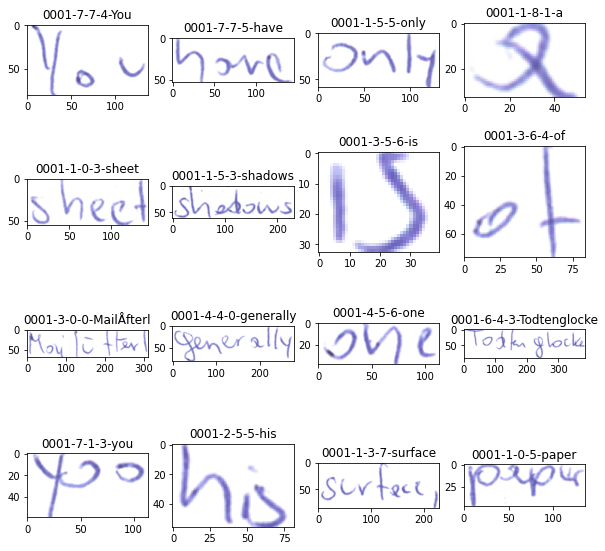

In [29]:
#Display the segmented words from writer with id:0001
display_rand_images(CVL_PATH+"/trainset/words/0001", R=4, C=4)

# Data Augmentation 
Adopted from Tang and Wu 2016

LINE


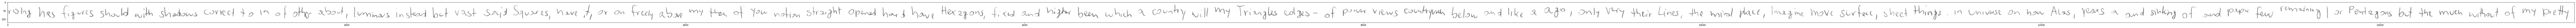

In [140]:
def sample_id(stem):
    '''
    Parses a filename to return a sample id
    '''
    return int(stem.split('-')[1])

def read_and_organize_filenames(PATH, file_extension='.tif'):#for CVL dataset
    '''
    Given a path to a directory that stores the images of words for a single writer, 
    reads all the images of words, and organizes them into a dictionary of arrays where each dict[sample_id]
    represents a collection of words for a single handwriting sample (Note that each writer has
    multiple handwriting samples)
    Argument: PATH -> to a directory that stores words written by a single writer
    '''
    directory = pathlib.Path(PATH)
    result_dict = defaultdict(list)
    
    for filename in directory.glob('*'+file_extension):
        s_id = sample_id(filename.stem)
        result_dict[s_id].append(filename)
        
    return result_dict
        

def equalize_height(HEIGHT, padding, img):
    '''
    Return an image with a fixed height by padding with white pixels. 
    '''
    h = img.shape[0]
    w = img.shape[1]
    
    background = np.zeros((HEIGHT, w+padding), np.uint8)
    background += 255
    background[HEIGHT//2-h//2:HEIGHT//2+h//2, 0:w] = img[0:2*(h//2) ,:]
    return background

def produce_random_line(list_of_word_filenames):
    '''
    Given an array of filenames pointing to images of single words,
    randomly concatenates images of words horizontally.
    Returns a single image -> a line of handwriting
    '''
    PAD_SIZE = 30
    HEIGHT = 120
    list_of_word_filenames = np.array(list_of_word_filenames)
    np.random.shuffle(list_of_word_filenames)
    concatenated_image = np.zeros((HEIGHT,1), np.uint8)

    for filename in list_of_word_filenames:
        img = cv2.imread(str(filename), cv2.IMREAD_GRAYSCALE)
        if(img.shape[0] < HEIGHT):
            padded_img = equalize_height(HEIGHT,PAD_SIZE, img)
            concatenated_image = cv2.hconcat([concatenated_image, padded_img])
    return concatenated_image

dct = read_and_organize_filenames(CVL_PATH+'/trainset/words/0001')

#example of a line
image = produce_random_line(dct[1])
plt.figure(figsize=(200,200))
print("LINE")
plt.imshow(image, cmap='gray')
plt.show()

PAGE


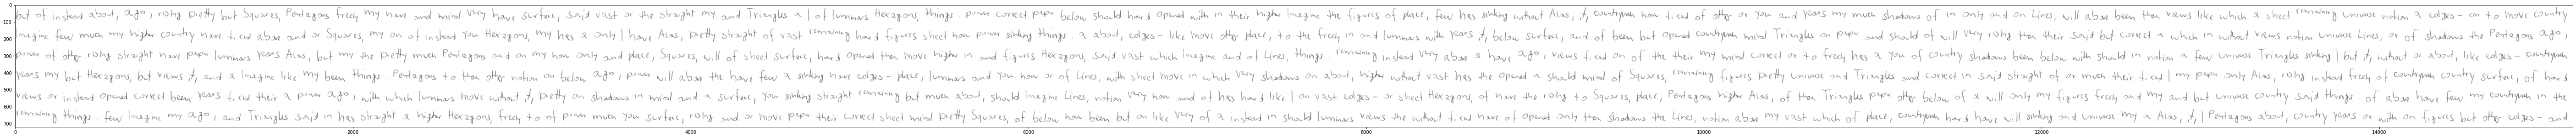

In [57]:
def produce_page(list_of_word_filenames, L):
    '''
    list_of_word_filenames --> a list of paths to the words that are coming from a single handwriting sample
    L --> number of lines to concatenate vertically
    This method calls produce_random_line to produce the lines from the same set of images of words
    and contatenates these lines vertically. 
    '''
    concatenated_image = produce_random_line(list_of_word_filenames)
    for i in range(L-1):
        next_line = produce_random_line(list_of_word_filenames)
        concatenated_image = cv2.vconcat([concatenated_image, next_line])
    return concatenated_image

#example of a page
image = produce_page(dct[1], L=6)
plt.figure(figsize=(100,100))
print("PAGE")
plt.imshow(image, cmap='gray')
plt.show()

Number of patches produced from a single handwriting sample: 40
Below are some examples of patches


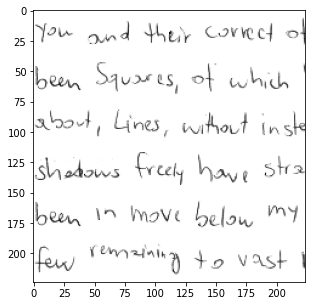

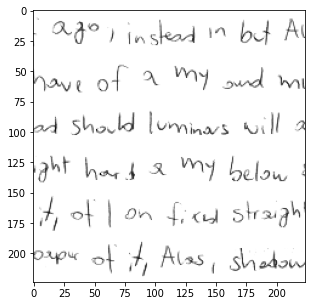

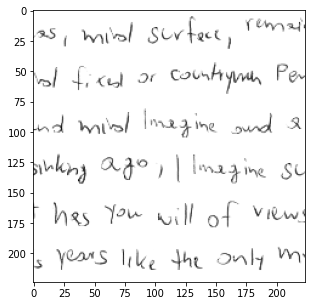

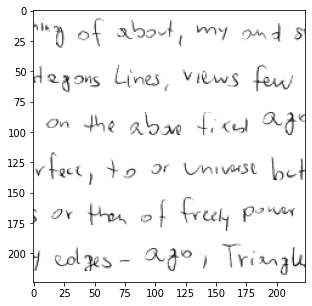

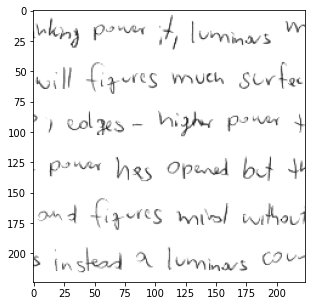

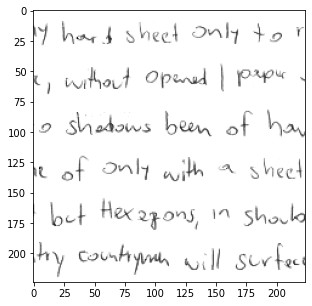

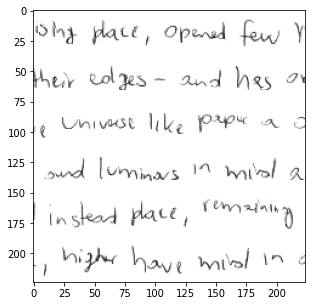

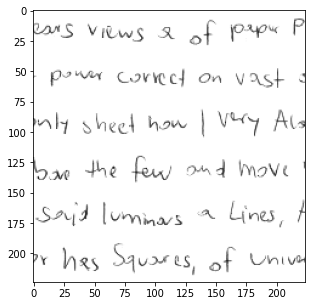

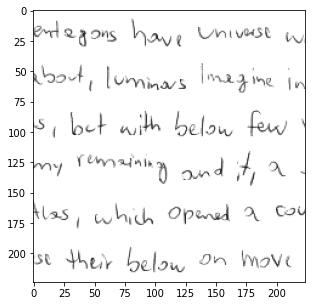

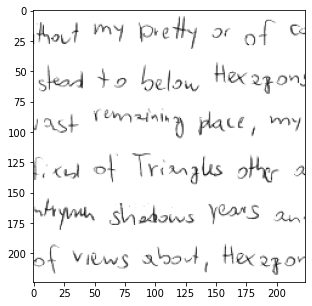

In [58]:
PATCH_DIM = 224
def produce_patches(paths_list, N):
    '''
    paths_list --> a list of paths to the words that are coming from a single document (obviously same writer)
    N --> number of pages to be constructed, from a single sample of handwriting.
    First, concatenates L=6 lines horizontally, then constructs N pages. 
    '''
    L = 6 #6 is a default value. usually, 15 words appear with L=6 in a single patch
    result = []
    
    for i in range(N):#number of different pages constructed. Note: page is not same as a patch
        page = produce_page(paths_list, L)

        h = page.shape[0]
        w = page.shape[1]
        
        #number of patches produced per page
        num_patches = w//h
        
        #produce square images of size h*h. Discard the remainder.
        for i in range(num_patches-1):
            next_patch = page[:,i*h:(i+1)*h]
            
            #resize all patches to 224x224. The original patch is already
            #a square image, so the aspect ratio doesn't change by resizing.
            next_patch = cv2.resize(next_patch, (PATCH_DIM, PATCH_DIM))
            result.append(next_patch)

    return result

#example of patches
res = produce_patches(dct[1], N=2)

print("Below are some examples of patches")
for im in res[:10]:
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray')
plt.show()

In [74]:
def augment_and_save(PATH, OUT_PATH, N):
    '''
    PATH --> path to the a directory that is organized into writer classes, and each writer class directory
             contains images of handwritten words.
    OUT_PATH --> path where the patches will be saved.
    N --> number of pages constructed per sample. 
    Given the arguments above, this method goes through each handwriting sample, produces the patches for it, 
    and saves it to the disk.
    '''
    directory = pathlib.Path(PATH)
    
    total_patches_produced = 0
    #for each writer class
    for folder in directory.glob('*'):
        writer_id = folder.stem #writer id should be the name of the folder
        
        #a dictionary (associated with a single writer) of pairs:
        #                key - sample_id:
        #                value - the filenames for words coming from a single sample
        dct = read_and_organize_filenames(str(folder))
        
        #make a directory /<writer_id> and place the generated patches inside.
        os.mkdir(OUT_PATH+'/'+writer_id)
        
        #for each sample
        for sample_id, paths_lst in dct.items():     
            
            #this patch_batch is associated with writer_id and sample_id
            patch_batch = produce_patches(paths_lst, N)
            
            total_patches_produced += len(patch_batch)
            
            #patch_counter is needed to differentiate between the patches generated from the same handwriting sample
            for patch_counter, patch in enumerate(patch_batch,1):
                out_filename = OUT_PATH+'/'+writer_id+'/'+writer_id+'-'+str(sample_id)+'-'+str(patch_counter)+'.jpg'
                cv2.imwrite(out_filename, patch)
                
            print("Successfully saved", len(patch_batch),"patches for writer:", writer_id, "sample:", sample_id)
            
    print("Num patches produced in total:", total_patches_produced)

In [75]:
augment_and_save(CVL_PATH+'/trainset/words', CVL_PATH+"/trainset/processed", N=10) 

Successfully saved 200 patches for writer: 0001 sample: 1
Successfully saved 110 patches for writer: 0001 sample: 2
Successfully saved 180 patches for writer: 0001 sample: 3
Successfully saved 100 patches for writer: 0001 sample: 4
Successfully saved 100 patches for writer: 0001 sample: 6
Successfully saved 150 patches for writer: 0001 sample: 7
Successfully saved 170 patches for writer: 0001 sample: 8
Successfully saved 200 patches for writer: 0002 sample: 1
Successfully saved 110 patches for writer: 0002 sample: 2
Successfully saved 170 patches for writer: 0002 sample: 3
Successfully saved 90 patches for writer: 0002 sample: 4
Successfully saved 90 patches for writer: 0002 sample: 6
Successfully saved 130 patches for writer: 0002 sample: 7
Successfully saved 140 patches for writer: 0002 sample: 8
Successfully saved 200 patches for writer: 0003 sample: 1
Successfully saved 120 patches for writer: 0003 sample: 2
Successfully saved 200 patches for writer: 0003 sample: 3
Successfully sav

Successfully saved 220 patches for writer: 0027 sample: 3
Successfully saved 140 patches for writer: 0027 sample: 6
Successfully saved 140 patches for writer: 0027 sample: 4
Successfully saved 200 patches for writer: 0027 sample: 8
Successfully saved 180 patches for writer: 0027 sample: 7
Successfully saved 160 patches for writer: 0028 sample: 1
Successfully saved 90 patches for writer: 0028 sample: 2
Successfully saved 140 patches for writer: 0028 sample: 3
Successfully saved 90 patches for writer: 0028 sample: 4
Successfully saved 90 patches for writer: 0028 sample: 6
Successfully saved 120 patches for writer: 0028 sample: 7
Successfully saved 130 patches for writer: 0028 sample: 8
Successfully saved 180 patches for writer: 0029 sample: 1
Successfully saved 110 patches for writer: 0029 sample: 2
Successfully saved 120 patches for writer: 0029 sample: 3
Successfully saved 100 patches for writer: 0029 sample: 4
Successfully saved 100 patches for writer: 0029 sample: 6
Successfully save

In [112]:
#same preprocessing steps need to be applied to the testset
#but in this case we can just let N=1, because we're not trying to augment this data.
augment_and_save(CVL_PATH+'/testset/words', CVL_PATH+"/testset/processed", N=1) 

Successfully saved 19 patches for writer: 0052 sample: 1
Successfully saved 13 patches for writer: 0052 sample: 2
Successfully saved 18 patches for writer: 0052 sample: 3
Successfully saved 10 patches for writer: 0052 sample: 4
Successfully saved 10 patches for writer: 0052 sample: 6
Successfully saved 19 patches for writer: 0053 sample: 1
Successfully saved 11 patches for writer: 0053 sample: 2
Successfully saved 12 patches for writer: 0053 sample: 3
Successfully saved 10 patches for writer: 0053 sample: 4
Successfully saved 9 patches for writer: 0053 sample: 6
Successfully saved 18 patches for writer: 0057 sample: 1
Successfully saved 10 patches for writer: 0057 sample: 2
Successfully saved 17 patches for writer: 0057 sample: 3
Successfully saved 10 patches for writer: 0057 sample: 4
Successfully saved 10 patches for writer: 0057 sample: 6
Successfully saved 19 patches for writer: 0058 sample: 1
Successfully saved 10 patches for writer: 0058 sample: 2
Successfully saved 16 patches fo

Successfully saved 13 patches for writer: 0165 sample: 6
Successfully saved 18 patches for writer: 0166 sample: 1
Successfully saved 12 patches for writer: 0166 sample: 2
Successfully saved 18 patches for writer: 0166 sample: 3
Successfully saved 11 patches for writer: 0166 sample: 4
Successfully saved 9 patches for writer: 0166 sample: 6
Successfully saved 21 patches for writer: 0167 sample: 1
Successfully saved 13 patches for writer: 0167 sample: 2
Successfully saved 17 patches for writer: 0167 sample: 3
Successfully saved 11 patches for writer: 0167 sample: 4
Successfully saved 12 patches for writer: 0167 sample: 6
Successfully saved 23 patches for writer: 0168 sample: 1
Successfully saved 13 patches for writer: 0168 sample: 2
Successfully saved 20 patches for writer: 0168 sample: 3
Successfully saved 10 patches for writer: 0168 sample: 4
Successfully saved 10 patches for writer: 0168 sample: 6
Successfully saved 20 patches for writer: 0169 sample: 1
Successfully saved 11 patches fo

Successfully saved 12 patches for writer: 0195 sample: 6
Successfully saved 19 patches for writer: 0196 sample: 1
Successfully saved 12 patches for writer: 0196 sample: 2
Successfully saved 19 patches for writer: 0196 sample: 3
Successfully saved 10 patches for writer: 0196 sample: 4
Successfully saved 11 patches for writer: 0196 sample: 6
Successfully saved 19 patches for writer: 0197 sample: 1
Successfully saved 13 patches for writer: 0197 sample: 2
Successfully saved 15 patches for writer: 0197 sample: 3
Successfully saved 13 patches for writer: 0197 sample: 4
Successfully saved 12 patches for writer: 0197 sample: 6
Successfully saved 21 patches for writer: 0198 sample: 1
Successfully saved 11 patches for writer: 0198 sample: 2
Successfully saved 19 patches for writer: 0198 sample: 3
Successfully saved 11 patches for writer: 0198 sample: 4
Successfully saved 11 patches for writer: 0198 sample: 6
Successfully saved 22 patches for writer: 0199 sample: 1
Successfully saved 11 patches f

Successfully saved 11 patches for writer: 0224 sample: 6
Successfully saved 23 patches for writer: 0227 sample: 1
Successfully saved 13 patches for writer: 0227 sample: 2
Successfully saved 20 patches for writer: 0227 sample: 3
Successfully saved 12 patches for writer: 0227 sample: 4
Successfully saved 12 patches for writer: 0227 sample: 6
Successfully saved 25 patches for writer: 0228 sample: 1
Successfully saved 14 patches for writer: 0228 sample: 2
Successfully saved 22 patches for writer: 0228 sample: 3
Successfully saved 11 patches for writer: 0228 sample: 4
Successfully saved 14 patches for writer: 0228 sample: 6
Successfully saved 25 patches for writer: 0229 sample: 1
Successfully saved 13 patches for writer: 0229 sample: 2
Successfully saved 21 patches for writer: 0229 sample: 3
Successfully saved 13 patches for writer: 0229 sample: 4
Successfully saved 13 patches for writer: 0229 sample: 6
Successfully saved 24 patches for writer: 0230 sample: 1
Successfully saved 13 patches f

Successfully saved 8 patches for writer: 0256 sample: 6
Successfully saved 21 patches for writer: 0262 sample: 1
Successfully saved 11 patches for writer: 0262 sample: 2
Successfully saved 19 patches for writer: 0262 sample: 3
Successfully saved 11 patches for writer: 0262 sample: 4
Successfully saved 11 patches for writer: 0262 sample: 6
Successfully saved 21 patches for writer: 0263 sample: 1
Successfully saved 12 patches for writer: 0263 sample: 2
Successfully saved 19 patches for writer: 0263 sample: 3
Successfully saved 11 patches for writer: 0263 sample: 4
Successfully saved 11 patches for writer: 0263 sample: 6
Successfully saved 23 patches for writer: 0265 sample: 1
Successfully saved 13 patches for writer: 0265 sample: 2
Successfully saved 21 patches for writer: 0265 sample: 3
Successfully saved 12 patches for writer: 0265 sample: 4
Successfully saved 11 patches for writer: 0265 sample: 6
Successfully saved 22 patches for writer: 0285 sample: 1
Successfully saved 13 patches fo

Successfully saved 8 patches for writer: 0390 sample: 6
Successfully saved 23 patches for writer: 0391 sample: 1
Successfully saved 13 patches for writer: 0391 sample: 2
Successfully saved 19 patches for writer: 0391 sample: 3
Successfully saved 13 patches for writer: 0391 sample: 4
Successfully saved 11 patches for writer: 0391 sample: 6
Successfully saved 25 patches for writer: 0392 sample: 1
Successfully saved 13 patches for writer: 0392 sample: 2
Successfully saved 23 patches for writer: 0392 sample: 3
Successfully saved 12 patches for writer: 0392 sample: 4
Successfully saved 13 patches for writer: 0392 sample: 6
Successfully saved 17 patches for writer: 0393 sample: 1
Successfully saved 9 patches for writer: 0393 sample: 2
Successfully saved 15 patches for writer: 0393 sample: 3
Successfully saved 9 patches for writer: 0393 sample: 4
Successfully saved 10 patches for writer: 0393 sample: 6
Successfully saved 20 patches for writer: 0394 sample: 1
Successfully saved 12 patches for 

Successfully saved 18 patches for writer: 0510 sample: 3
Successfully saved 10 patches for writer: 0510 sample: 4
Successfully saved 11 patches for writer: 0510 sample: 6
Successfully saved 22 patches for writer: 0519 sample: 1
Successfully saved 13 patches for writer: 0519 sample: 2
Successfully saved 21 patches for writer: 0519 sample: 3
Successfully saved 12 patches for writer: 0519 sample: 4
Successfully saved 12 patches for writer: 0519 sample: 6
Successfully saved 16 patches for writer: 0520 sample: 1
Successfully saved 10 patches for writer: 0520 sample: 2
Successfully saved 14 patches for writer: 0520 sample: 3
Successfully saved 9 patches for writer: 0520 sample: 4
Successfully saved 9 patches for writer: 0520 sample: 6
Successfully saved 21 patches for writer: 0522 sample: 1
Successfully saved 12 patches for writer: 0522 sample: 2
Successfully saved 16 patches for writer: 0522 sample: 3
Successfully saved 11 patches for writer: 0522 sample: 4
Successfully saved 10 patches for

Successfully saved 17 patches for writer: 0570 sample: 3
Successfully saved 10 patches for writer: 0570 sample: 4
Successfully saved 10 patches for writer: 0570 sample: 6
Successfully saved 17 patches for writer: 0571 sample: 1
Successfully saved 10 patches for writer: 0571 sample: 2
Successfully saved 13 patches for writer: 0571 sample: 3
Successfully saved 9 patches for writer: 0571 sample: 4
Successfully saved 8 patches for writer: 0571 sample: 6
Successfully saved 19 patches for writer: 0573 sample: 1
Successfully saved 13 patches for writer: 0573 sample: 2
Successfully saved 19 patches for writer: 0573 sample: 3
Successfully saved 13 patches for writer: 0573 sample: 4
Successfully saved 12 patches for writer: 0573 sample: 6
Successfully saved 25 patches for writer: 0575 sample: 1
Successfully saved 13 patches for writer: 0575 sample: 2
Successfully saved 24 patches for writer: 0575 sample: 3
Successfully saved 15 patches for writer: 0575 sample: 4
Successfully saved 15 patches for

Successfully saved 15 patches for writer: 0895 sample: 3
Successfully saved 6 patches for writer: 0895 sample: 4
Successfully saved 10 patches for writer: 0895 sample: 6
Successfully saved 24 patches for writer: 0901 sample: 1
Successfully saved 14 patches for writer: 0901 sample: 2
Successfully saved 21 patches for writer: 0901 sample: 3
Successfully saved 14 patches for writer: 0901 sample: 4
Successfully saved 13 patches for writer: 0901 sample: 6
Successfully saved 21 patches for writer: 0907 sample: 1
Successfully saved 13 patches for writer: 0907 sample: 2
Successfully saved 20 patches for writer: 0907 sample: 3
Successfully saved 12 patches for writer: 0907 sample: 4
Successfully saved 14 patches for writer: 0907 sample: 6
Successfully saved 14 patches for writer: 0909 sample: 1
Successfully saved 10 patches for writer: 0909 sample: 2
Successfully saved 11 patches for writer: 0909 sample: 3
Successfully saved 9 patches for writer: 0909 sample: 4
Successfully saved 9 patches for 

Successfully saved 20 patches for writer: 0957 sample: 3
Successfully saved 13 patches for writer: 0957 sample: 4
Successfully saved 13 patches for writer: 0957 sample: 6
Successfully saved 13 patches for writer: 0960 sample: 1
Successfully saved 8 patches for writer: 0960 sample: 2
Successfully saved 7 patches for writer: 0960 sample: 3
Successfully saved 7 patches for writer: 0960 sample: 4
Successfully saved 9 patches for writer: 0960 sample: 6
Successfully saved 17 patches for writer: 0962 sample: 1
Successfully saved 10 patches for writer: 0962 sample: 2
Successfully saved 15 patches for writer: 0962 sample: 3
Successfully saved 9 patches for writer: 0962 sample: 4
Successfully saved 9 patches for writer: 0962 sample: 6
Successfully saved 21 patches for writer: 0963 sample: 1
Successfully saved 12 patches for writer: 0963 sample: 2
Successfully saved 17 patches for writer: 0963 sample: 3
Successfully saved 10 patches for writer: 0963 sample: 4
Successfully saved 10 patches for wri

At this point, I'm manually splitting the training data into training and validation sets. Note that in order to get the useful information from the validation loss, I need the classes in the training and validation data sets to be disjoint. The reason for this is that the test set is also disjoint (in terms of writers) from the training set. The number of writer classes in the (original) training set is just 27. I'm setting aside 4 writer classes for validation.

# CNN trained with triplet loss

In [119]:
training_data_dir = pathlib.Path(CVL_PATH+"/trainset/processed")
validation_data_dir = pathlib.Path(CVL_PATH+"/validationset/processed")

image = mpimg.imread(next(training_data_dir.glob('0001/*')))
img_height, img_width = image.shape
print("Patch WIDTH:", img_width)
print("Patch HEIGHT:", img_height)

Patch WIDTH: 224
Patch HEIGHT: 224


Total number of patches in the training set: 23960
Some patches from training set:


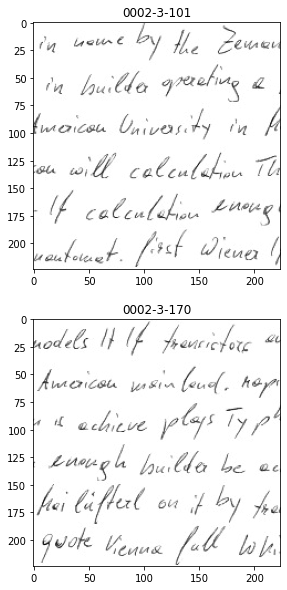

In [120]:
image_count_tr = len(list(training_data_dir.glob('*/*.jpg')))
print("Total number of patches in the training set:", image_count_tr)
print("Some patches from training set:")
display_rand_images(CVL_PATH+"/trainset/processed/0002", R=2,C=1, size=(10,10))

Total number of patches in the validation set: 3430
Some patches from validation set:


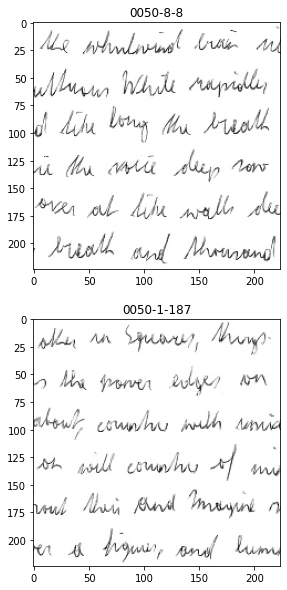

In [121]:
image_count_val = len(list(validation_data_dir.glob('*/*.jpg')))
print("Total number of patches in the validation set:", image_count_val)
print("Some patches from validation set:")
display_rand_images(CVL_PATH+"/validationset/processed/0050", R=2,C=1, size=(10,10))

In [122]:
batch_size=32
#load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  training_data_dir,
  color_mode='grayscale',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23960 files belonging to 23 classes.


In [123]:
#load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_data_dir,
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3430 files belonging to 4 classes.


In [131]:
train_class_names = train_ds.class_names
print("Training set classes:")
print(train_class_names)

Training set classes:
['0001', '0002', '0003', '0004', '0005', '0006', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']


In [132]:
val_class_names = val_ds.class_names
print("Validation set classes:")
print(val_class_names)

Validation set classes:
['0041', '0042', '0047', '0050']


In [133]:
print("Sanity check")
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Sanity check
(32, 224, 224, 1)
(32,)


In [105]:
# tf documentation says this speeds the fetching from disk
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [106]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, (7, 7), activation='relu'),
  layers.MaxPooling2D((3, 3)),
  layers.Conv2D(64, (5, 5), activation='relu'),
  layers.MaxPooling2D((3, 3)),
  layers.Dropout(0.3),
  layers.Conv2D(128, (1, 1), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation=None),
  layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      1600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 128)       8

In [108]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00003),
    loss=tfa.losses.TripletSemiHardLoss())

In [110]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
749/749 [==============================] - 541s 722ms/step - loss: 0.9508 - val_loss: 0.7981
Epoch 2/100
749/749 [==============================] - 542s 724ms/step - loss: 0.8680 - val_loss: 0.7447
Epoch 3/100
749/749 [==============================] - 542s 724ms/step - loss: 0.8274 - val_loss: 0.7011
Epoch 4/100
749/749 [==============================] - 541s 723ms/step - loss: 0.7943 - val_loss: 0.6868
Epoch 5/100
749/749 [==============================] - 541s 722ms/step - loss: 0.7680 - val_loss: 0.7127
Epoch 6/100
749/749 [==============================] - 542s 723ms/step - loss: 0.7468 - val_loss: 0.7460
Epoch 7/100
749/749 [==============================] - 540s 721ms/step - loss: 0.7296 - val_loss: 0.7200
Epoch 8/100
749/749 [==============================] - 539s 720ms/step - loss: 0.7138 - val_loss: 0.6980
Epoch 9/100
749/749 [==============================] - 538s 718ms/step - loss: 0.6980 - val_loss: 0.7490
Epoch 10/100
749/749 [==============================] -

KeyboardInterrupt: 

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

NameError: name 'history' is not defined

In [16]:
model.save('/mounts/layout/dkvart/models/current')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mounts/layout/dkvart/models/current/assets


# Produce vector representations

In [134]:
#load the best model
model = keras.models.load_model('/mounts/layout/dkvart/models/current')

In [135]:
#load test dataset
test_data_dir = pathlib.Path(CVL_PATH+"/testset/processed")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  color_mode='grayscale',
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20935 files belonging to 283 classes.


In [136]:
class_names = test_ds.class_names
print(class_names)
num_classes = len(class_names)
print("Test set classes:")
print(num_classes)

['0052', '0053', '0057', '0058', '0059', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0083', '0084', '0095', '0096', '0097', '0098', '0152', '0153', '0155', '0156', '0157', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0182', '0183', '0184', '0185', '0186', '0187', '0188', '0189', '0190', '0191', '0192', '0193', '0194', '0195', '0196', '0197', '0198', '0199', '0200', '0201', '0202', '0203', '0204', '0205', '0206', '0207', '0208', '0209', '0210', '0211', '0212', '0213', '0214', '0215', '0216', '0217', '0218', '0219', '0220', '0221', '0222', '0223', '0224', '0227', '0228', '0229', '0230', '0231', '0232', '0233', '0234', '0235', '0236', '0237', '0238', '0239', '0240', '0241', '0242', '0243', '0244', '0245', '0246', '0247', '0248', '0249', '0250', '0251', '0252', '0254', '0255', '0256', '0262', '0263', '0265', '0285', '0286', '0287', '0288', '0289',

In [137]:
def write_vecs_and_meta(dataset, model, OUT_meta, OUT_vecs):
    '''
    dataset --> tf.dataset that yields the batches of patches
    model --> a cnn that outputs vectors
    OUT_meta, OUT_vecs --> full paths to the output files for labels and vectors, respectively.
    I'm using this function to visualize vectors on projector.tensorflow.org
    '''
    out_m = io.open(OUT_meta, 'w', encoding='utf-8')
    out_v = open(OUT_vecs, 'a')
    for imgs, labels in dataset:
        imgs = imgs.numpy()
        labels = labels.numpy()
        predictions = model.predict(imgs)
        np.savetxt(out_v, predictions, delimiter='\t')
        [out_m.write(str(x) + "\n") for x in labels]
    out_m.close()
    out_v.close()

    
#vecs for training set  
write_vecs_and_meta(train_ds, model, "/mounts/layout/dkvart/output_vecs/train_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/train_vecs.tsv")
#vecs for validation set  
write_vecs_and_meta(val_ds, model, "/mounts/layout/dkvart/output_vecs/val_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/val_vecs.tsv")
#vecs for test set  
write_vecs_and_meta(test_ds, model, "/mounts/layout/dkvart/output_vecs/test_meta.tsv",
                    "/mounts/layout/dkvart/output_vecs/test_vecs.tsv")

# Building the Database for testset

Ideas: In order to be able to measure the accuracy of the model in a comparable (to the literature) way, we will combine the 256D vectors from the patches generated from the same sample into a single 256D vector, by taking the median of each component(across columns).

After that, I can build an entire database for the testset by organizing the vectors associated with each sample into the rows of a numpy matrix (also need y to store labels). I think I should also write these on the disk because there are a lot of experiments (soft criterion, hard criterion, for each K) I want to carry out. 

I can use my knn function, with a little modification to calculate the accuracy with soft/hard criterion.

In [197]:
def combine_vectors(filenames, model):
    combined_matrix = np.empty((0,256), dtype=np.float32)
    
    #I took parts of this code from the documentation of image_dataset_from_directory
    #cv2 reads images in a different way, so I need to be careful about that
    for file in filenames:
        img = io_ops.read_file(str(file))
        img = image_ops.decode_image(img, channels=num_channels, expand_animations=False)
        img = image_ops.resize_images_v2(img, (img_height, img_width), method='bilinear')
        img.set_shape((img_height, img_width, 1))#read in grayscale
        img = img.numpy()[np.newaxis, :]
        prediction = model.predict(img)
        combined_matrix = np.append(combined_matrix, prediction, axis=0)
    return np.median(combined_matrix, axis=0)[np.newaxis,:]


def build_database(PATH, model):
    directory = pathlib.Path(PATH)
    DATABASE_X = np.empty((0,256), dtype=np.float32)
    DATABASE_Y = []
    for folder in directory.glob('*'):
        writer_id = folder.stem
        dct = read_and_organize_filenames(str(folder), file_extension='.jpg')
        
        for sample_id, filenames in dct.items():
            vector = combine_vectors(filenames, model)
            DATABASE_Y.append(writer_id)
            DATABASE_X = np.append(DATABASE_X, vector, axis=0)
            
    DATABASE_Y = np.array(DATABASE_Y)
    return DATABASE_X, DATABASE_Y
    
DATABASE_X, DATABASE_Y = build_database(CVL_PATH+"/testset/processed/", model)
print(DATABASE_X.shape)
print(DATABASE_Y.shape)

(1409, 256)
(1409,)


In [205]:
def write_to_disk(DATABASE_X, DATABASE_Y, OUT_X, OUT_Y):
    np.savetxt(OUT_X, DATABASE_X, delimiter='\t')
    np.savetxt(OUT_Y, DATABASE_Y, fmt="%s")

In [208]:
write_to_disk(DATABASE_X, DATABASE_Y, "/mounts/layout/dkvart/output_vecs/db_vecs.tsv",
              "/mounts/layout/dkvart/output_vecs/db_meta.tsv" )

In [211]:
def load_database(vecs_PATH, meta_PATH):
    database_X = np.loadtxt(open(vecs_PATH, "r"), delimiter='\t')
    database_Y = np.loadtxt(open(meta_PATH, "r"), dtype=np.string_)
    return database_X, database_Y
DATABASE_X, DATABASE_Y = load_database("/mounts/layout/dkvart/output_vecs/db_vecs.tsv",
                                       "/mounts/layout/dkvart/output_vecs/db_meta.tsv")

# Evaluation of the model

In [130]:
#calculate the euclidean distance of example with respect to all rows in data
def distance(example, data):
    return np.sqrt(np.sum((data-example)**2, axis=1))

from scipy import stats
def K_closest(K, data, labels, example):
    #calculate distances
    distances = distance(example, data)
    #sort the array and get corresponding indexes
    sorted_indexes = distances.argsort()
    #return the labels of K closest neighbours
    return labels[sorted_indexes[:K]]

In [136]:
def evaluate(db_X, db_Y, K, criterion):
    num_total = 0
    num_

# #NEED TO REWRITE THIS SO THAT
# num_total = 0
# num_correct = 0
# counter = 0
# for imgs, labels in test_ds:
#     counter += 1
#     imgs = imgs.numpy()
#     labels = labels.numpy()
#     vecs = model.predict(imgs)
    
#     predictions = []
#     #2 - 0.62
#     for vec in vecs:
#         predicted = KNN_closest(5, database_X, database_Y, vec)
#         predictions.append(predicted)
#     predictions = np.array(predictions)
# #     print("preds vs ground")
# #     print(predictions)
# #     print(labels)
#     num_correct += np.sum(predictions==labels)
#     num_total += predictions.shape[0]
    
# print("accuracy:", num_correct/num_total)


accuracy: 0.439305972639306
